In [1]:
import psycopg2
from io import StringIO
import pandas as pd
import os
import traceback
from sqlalchemy import create_engine, MetaData
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RepeatedKFold, GroupKFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score
from lightgbm import LGBMClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from rpy2 import robjects
from rpy2.robjects import pandas2ri
from rpy2.interactive import process_revents
process_revents.start()
def load_rdata_file(filename):
    r_data = robjects.r['get'](robjects.r['load'](filename))
    df = pandas2ri.ri2py(r_data)
    return df

In [3]:
pd.set_option('display.max_columns', None)

In [5]:
limit = 10000
df = load_rdata_file("5v_cleandf.rdata")

In [7]:
df.to_csv('/disco-grande/datos.csv', index=False)

In [6]:
df.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,arrivalmonth,arrivalday,arrivalhour_bin,previousdispo,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,acutemi,acutphanm,adjustmentdisorders,adltrespfl,alcoholrelateddisorders,allergy,amniosdx,analrectal,anemia,aneurysm,anxietydisorders,appendicitis,artembolism,asppneumon,asthma,attentiondeficitconductdisruptivebeha,backproblem,biliarydx,birthasphyx,birthtrauma,bladdercncr,blindness,bnignutneo,bonectcncr,bph,brainnscan,breastcancr,breastdx,brnchlngca,bronchitis,burns,cardiaarrst,cardiacanom,carditis,cataract,cervixcancr,chestpain,chfnonhp,chrkidneydisease,coaghemrdx,coloncancer,comabrndmg,complicdevi,complicproc,conduction,contraceptiv,copd,coronathero,crushinjury,cysticfibro,deliriumdementiaamnesticothercognitiv,developmentaldisorders,diabmelnoc,diabmelwcm,disordersusuallydiagnosedininfancych,diverticulos,dizziness,dminpreg,dysrhythmia,earlylabor,ecodesadverseeffectsofmedicalcare,ecodesadverseeffectsofmedicaldrugs,ecodescutpierce,ecodesdrowningsubmersion,ecodesfall,ecodesfirearm,ecodesfireburn,ecodesmachinery,ecodesmotorvehicletrafficmvt,ecodesnaturalenvironment,ecodesotherspecifiedandclassifiable,ecodesotherspecifiednec,ecodespedalcyclistnotmvt,ecodesplaceofoccurrence,ecodespoisoning,ecodesstruckbyagainst,ecodessuffocation,ecodestransportnotmvt,ecodesunspecified,ectopicpreg,encephalitis,endometrios,epilepsycnv,esophcancer,esophgealdx,exameval,eyeinfectn,fatigue,femgenitca,feminfertil,fetaldistrs,fluidelcdx,fuo,fxarm,fxhip,fxleg,fxskullfac,gangrene,gasduoulcer,gastritis,gastroent,giconganom,gihemorrhag,giperitcan,glaucoma,goutotcrys,guconganom,hdnckcancr,headachemig,hemmorhoids,hemorrpreg,hepatitis,hivinfectn,hodgkinsds,hrtvalvedx,htn,htncomplicn,htninpreg,hyperlipidem,immunitydx,immunizscrn,impulsecontroldisordersnec,inducabortn,infectarth,influenza,infmalegen,intestinfct,intobstruct,intracrninj,jointinjury,kidnyrnlca,lateeffcvd,leukemias,liveborn,liveribdca,longpregncy,lowbirthwt,lungexternl,lymphenlarg,maintchemr,malgenitca,maligneopls,malposition,meningitis,menopausldx,menstrualdx,miscellaneousmentalhealthdisorders,mooddisorders,mouthdx,ms,multmyeloma,mycoses,nauseavomit,neoplsmunsp,nephritis,nervcongan,nonepithca,nonhodglym,nutritdefic,obrelatedperintrauma,opnwndextr,opnwndhead,osteoarthros,osteoporosis,otacqdefor,otaftercare,otbnignneo,otbonedx,otcirculdx,otcomplbir,otconganom,otconntiss,otdxbladdr,otdxkidney,otdxstomch,otendodsor,otfemalgen,othbactinf,othcnsinfx,othematldx,othercvd,othereardx,otheredcns,othereyedx,othergidx,othergudx,otherinjury,otherpregnancyanddeliveryincludingnormal,otherscreen,othfracture,othheartdx,othinfectns,othliverdx,othlowresp,othmalegen,othnervdx,othskindx,othveindx,otinflskin,otitismedia,otjointdx,otnutritdx,otperintdx,otpregcomp,otprimryca,otrespirca,otupprresp,otuprspin,ovariancyst,ovarycancer,pancreascan,pancreasdx,paralysis,parkinsons,pathologfx,pelvicobstr,perintjaund,peripathero,peritonitis,personalitydisorders,phlebitis,pid,pleurisy,pneumonia,poisnnonmed,poisnotmed,poisonpsych,precereoccl,prevcsectn,prolapse,prostatecan,pulmhartdx,rctmanusca,rehab,respdistres,retinaldx,rheumarth,schizophreniaandotherpsychoticdisorde,screeningandhistoryofmentalhealthan,septicemia,septicemiaexceptinlabor,sexualinfxs,shock,sicklecell,skininfectn,skinmelanom,sle,socialadmin,spincorinj,spontabortn,sprain,stomchcancr,substancerelateddisorders,suicideandintentionalselfinflictedin,superficinj,syncope,teethdx,testiscancr,thyroidcncr,thyroiddsor,tia,tonsillitis,tuberculosis,ulceratcol,ulcerskin,umbilcord,unclassified,urinstone,urinyorgca,uteruscancr,uti,varicosevn,viralinfect,whtblooddx,n_edvisits,n_admissions,absolutelymphocytecount_last,acetonebld_last,alanineaminotransferase(alt)_last,albumin_last,alkphos_last,anc(absneutrophilcount)_last,aniongap_last,aspartateaminotransferase(ast)_last,"b-typenatriureticpeptide,pro(probnp)_last",baseexcess(poc)_last,"baseex

In [6]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols = [col for col in categorical_cols if col != 'disposition']

In [7]:
float_feature_mask = df.dtypes==np.float64
int64_feature_mask = df.dtypes==np.int64
int32_feature_mask = df.dtypes==np.int32
uint8_feature_mask = df.dtypes==np.uint8
numeric_cols = df.columns[uint8_feature_mask].tolist() + df.columns[float_feature_mask].tolist() + df.columns[int64_feature_mask].tolist() + df.columns[int32_feature_mask].tolist()

In [8]:
len(numeric_cols) + len(categorical_cols) - len(df.columns)

-1

In [9]:
categorical_cols

['dep_name',
 'esi',
 'gender',
 'ethnicity',
 'race',
 'lang',
 'religion',
 'maritalstatus',
 'employstatus',
 'insurance_status',
 'arrivalmode',
 'arrivalmonth',
 'arrivalday',
 'arrivalhour_bin',
 'previousdispo']

In [10]:
df["disposition"] =  df["disposition"].apply(lambda x: 1 if x  == 'Admit' else 0)

In [11]:
# ONE HOT ENCODING de categoricos
df = pd.get_dummies(df, columns=categorical_cols)

In [12]:
len(df.columns)

1061

In [13]:
df.columns.to_series().groupby(df.dtypes).groups

{dtype('uint8'): Index(['dep_name_A', 'dep_name_B', 'dep_name_C', 'esi_1', 'esi_2', 'esi_3',
        'esi_4', 'esi_5', 'gender_Female', 'gender_Male',
        ...
        'previousdispo_AMA', 'previousdispo_Admit', 'previousdispo_Discharge',
        'previousdispo_Eloped', 'previousdispo_LWBS after Triage',
        'previousdispo_LWBS before Triage', 'previousdispo_No previous dispo',
        'previousdispo_Observation', 'previousdispo_Send to L&D',
        'previousdispo_Transfer to Another Facility'],
       dtype='object', length=104),
 dtype('int32'): Index(['age', 'n_edvisits', 'n_admissions', 'cc_abdominalcramping',
        'cc_abdominaldistention', 'cc_abdominalpain',
        'cc_abdominalpainpregnant', 'cc_abnormallab', 'cc_abscess',
        'cc_addictionproblem',
        ...
        'cc_vaginaldischarge', 'cc_vaginalpain', 'cc_weakness', 'cc_wheezing',
        'cc_withdrawal-alcohol', 'cc_woundcheck', 'cc_woundinfection',
        'cc_woundre-evaluation', 'cc_wristinjury', 'cc_

In [16]:
df.dtypes

age                                             int32
disposition                                     int64
2ndarymalig                                   float64
abdomhernia                                   float64
abdomnlpain                                   float64
abortcompl                                    float64
acqfootdef                                    float64
acrenlfail                                    float64
acutecvd                                      float64
acutemi                                       float64
acutphanm                                     float64
adjustmentdisorders                           float64
adltrespfl                                    float64
alcoholrelateddisorders                       float64
allergy                                       float64
amniosdx                                      float64
analrectal                                    float64
anemia                                        float64
aneurysm                    

In [15]:
df.head(20)

age  disposition  2ndarymalig  abdomhernia  abdomnlpain  abortcompl  \
1    40            0          0.0          0.0          0.0         0.0   
2    66            0          0.0          0.0          0.0         0.0   
3    66            0          0.0          0.0          0.0         0.0   
4    66            0          0.0          0.0          0.0         0.0   
5    84            1          0.0          0.0          0.0         0.0   
6    86            0          0.0          0.0          0.0         0.0   
7    86            1          0.0          0.0          0.0         0.0   
8    87            0          0.0          0.0          0.0         0.0   
9    75            1          0.0          0.0          0.0         0.0   
10   75            1          0.0          0.0          0.0         0.0   
11   76            1          0.0          0.0          0.0         0.0   
12   77            1          0.0          0.0          0.0         0.0   
13   52            0          0.0          0.0          0.0         0.0   
14   53            1          0.0          0.0          0.0         0.0   
15   53            1          0.0          0.0          0.0         0.0   
16   53            1          0.0          0.0          0.0         0.0   
17   53            0          0.0          0.0          0.0         0.0   
18   53            1          0.0          0.0          0.0         0.0   
19   53            0          0.0          0.0          0.0         0.0   
20   33            1          0.0          0.0          0.0         0.0   

    acqfootdef  acrenlfail  acutecvd  acutemi  acutphanm  adjustmentdisorders  \
1          0.0         0.0       0.0      0.0        0.0                  0.0   
2          0.0         0.0       0.0      0.0        0.0                  0.0   
3          0.0         0.0       0.0      0.0        0.0                  0.0   
4          0.0         0.0       0.0      0.0        0.0                  0.0   
5          0.0         0.0       0.0      0.0        0.0                  0.0   
6          0.0         0.0       0.0      0.0        0.0                  0.0   
7          0.0         0.0       0.0      0.0        0.0                  0.0   
8          0.0         0.0       0.0      0.0        0.0                  0.0   
9          0.0         0.0       0.0      0.0        0.0                  0.0   
10         0.0         0.0       0.0      0.0        0.0                  0.0   
11         0.0         0.0       0.0      0.0        0.0                  0.0   
12         0.0         0.0       0.0      0.0        0.0                  0.0   
13         0.0         0.0       0.0      0.0        0.0                  0.0   
14         0.0         0.0       0.0      0.0        0.0                  0.0   
15         0.0         0.0       0.0      0.0        0.0                  0.0   
16         0.0         0.0       0.0      0.0        0.0                  0.0   
17         0.0         0.0       0.0      0.0        0.0                  0.0   
18         0.0         0.0       0.0      0.0        0.0                  0.0   
19         0.0         0.0       0.0      0.0        0.0                  0.0   
20         0.0         0.0       0.0      0.0        0.0                  0.0   

    adltrespfl  alcoholrelateddisorders  allergy  amniosdx  analrectal  \
1          0.0                      0.0      0.0       0.0         0.0   
2          0.0                      0.0      0.0       0.0         0.0   
3          0.0                      0.0      0.0       0.0         0.0   
4          0.0                      0.0      0.0       0.0         0.0   
5          0.0                      0.0      0.0       0.0         0.0   
6          0.0                      0.0      0.0       0.0         0.0   
7          0.0                      0.0      0.0       0.0         0.0   
8          0.0                      0.0      0.0       0.0         0.0   
9          0.0                      0.0      0.0       0.0  

In [48]:
df.describe()

age    disposition    2ndarymalig    abdomhernia  \
count  5.604860e+05  560486.000000  560486.000000  560486.000000   
mean  -4.209626e+04       0.297310       0.002155       0.030634   
std    9.513492e+06       0.457074       0.046375       0.172324   
min   -2.147484e+09       0.000000       0.000000       0.000000   
25%    3.200000e+01       0.000000       0.000000       0.000000   
50%    4.900000e+01       0.000000       0.000000       0.000000   
75%    6.400000e+01       1.000000       0.000000       0.000000   
max    1.080000e+02       1.000000       1.000000       1.000000   

         abdomnlpain     abortcompl     acqfootdef     acrenlfail  \
count  560486.000000  560486.000000  560486.000000  560486.000000   
mean        0.014807       0.000023       0.005179       0.009968   
std         0.120779       0.004816       0.071782       0.099342   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

            acutecvd        acutemi      acutphanm  adjustmentdisorders  \
count  560486.000000  560486.000000  560486.000000        560486.000000   
mean        0.051054       0.035844       0.000459             0.001633   
std         0.220108       0.185901       0.021408             0.040371   
min         0.000000       0.000000       0.000000             0.000000   
25%         0.000000       0.000000       0.000000             0.000000   
50%         0.000000       0.000000       0.000000             0.000000   
75%         0.000000       0.000000       0.000000             0.000000   
max         1.000000       1.000000       1.000000             1.000000   

          adltrespfl  alcoholrelateddisorders        allergy       amniosdx  \
count  560486.000000            560486.000000  560486.000000  560486.000000   
mean        0.007122                 0.055909       0.045860       0.000153   
std         0.084093                 0.229745       0.209182       0.012386   
min         0.000000                 0.000000       0.000000       0.000000   
25%         0.000000                 0.000000       0.000000       0.000000   
50%         0.000000                 0.000000       0.000000       0.000000   
75%         0.000000                 0.000000       0.000000       0.000000   
max         1.000000                 1.000000       1.000000       1.000000   

          analrectal         anemia       aneurysm  anxietydisorders  \
count  560486.000000  560486.000000  560486.000000     560486.000000   
mean        0.004644       0.084737       0.010712          0.199432   
std         0.067990       0.278490       0.102944          0.399574   
min         0.000000       0.000000       0.000000          0.000000   
25%         0.000000       0.000000       0.000000          0.000000   
50%         0.000000       0.000000       0.000000          0.000000   
75%         0.000000       0.000000       0.000000          0.000000   
max         1.000000       1.000000       1.000000          1.000000   

        appendicitis    artembolism     asppneumon         asthma  \
count  560486.000000  560486.000000  560486.000000  560486.000000   
mean        0.001513       0.001167       0.002396       0.190456   
std         0.038868       0.034139       0.048892       0.392661   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

       attentiondeficitconductdisruptivebeha    backproblem      biliarydx  \
count                          560486.000000

In [17]:
null_columns= []
for col in df.columns:
    num_nulos = df[col].isna().sum()
    if num_nulos:
        null_columns.append((col, num_nulos))

In [18]:
null_columns

[('absolutelymphocytecount_last', 342560),
 ('acetonebld_last', 560090),
 ('alanineaminotransferase(alt)_last', 434832),
 ('albumin_last', 448952),
 ('alkphos_last', 433755),
 ('anc(absneutrophilcount)_last', 340278),
 ('aniongap_last', 348985),
 ('aspartateaminotransferase(ast)_last', 437527),
 ('b-typenatriureticpeptide,pro(probnp)_last', 549577),
 ('baseexcess(poc)_last', 519337),
 ('baseexcess,venous(poc)_last', 544752),
 ('basos_last', 340264),
 ('basosabs_last', 513915),
 ('benzodiazepinesscreen,urine,noconf._last', 560485),
 ('bilirubindirect_last', 505193),
 ('bilirubintotal_last', 434647),
 ('bun_last', 347614),
 ('bun/creatratio_last', 393885),
 ('calcium_last', 346287),
 ('calculatedco2(poc)_last', 515093),
 ('calculatedhco3(poc)i_last', 521492),
 ('calculatedo2saturation(poc)_last', 519388),
 ('chloride_last', 347535),
 ('cktotal_last', 548194),
 ('co2_last', 347665),
 ('co2calculated,venous(poc)_last', 544784),
 ('co2,poc_last', 509235),
 ('creatinine_last', 347595),
 ('d-

In [21]:
for col, l in null_columns:
    df[col] = df[col].fillna(0).to_sparse(fill_value=0)

In [33]:
# arr = []
# for col in numeric_cols:
#     uq = df[col].unique()
#     l = len(uq)
    
#     all_scalar = np.sum([a % 1 == 0 for a in uq]) == l
#     b = uq[l - 1] == (l - 1)
#     if all_scalar and b:
#         arr.append([col, df[col].unique()])
# pd.DataFrame(arr, columns=["col","values"]).to_csv("./out.csv", sep=';', index=False, header=False)
# pd.DataFrame(df.columns.tolist(), columns=["col_name"]).to_csv('./todas_columnas.csv', index=False, header=False)

/disco-grande/projects/proyecto-hospital/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
X = df[[col  for col in df.columns if col != 'disposition']]
Y = df['disposition']
random_state=42
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=random_state)
del X
del Y

In [ ]:
n_splits = 4
def execute_model_base(model, cv = None, print_score=True, plot = True):
  if cv:
    for (train_idx, test_idx) in cv.split(X_train,Y_train):
      model.fit(X_train.iloc[train_idx], Y_train.iloc[train_idx])
  else:
    model.fit(X_train, Y_train)

  Y_pred = model.predict(X_test)
  score = accuracy_score(Y_test, Y_pred)
  precision = precision_score(Y_test, Y_pred)
  recall = recall_score(Y_test, Y_pred)
  if print_score:
    print("Score = {0:.5f} ".format(score))
    print("Precision = {0:.5f} ".format(precision))
    print("Recall = {0:.5f} ".format(recall))  
  conf_matrix = confusion_matrix(Y_pred, Y_test)
  if plot:
    sns.heatmap(conf_matrix,annot=True,fmt="d")
    plt.show()
def execute_model_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=KFold(n_splits=n_splits, random_state = random_state), *args, **kwargs)
def execute_model_stratified_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=StratifiedKFold(n_splits=n_splits, random_state = random_state), *args, **kwargs)
def execute_model_repeated_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=RepeatedKFold(n_repeats=8, n_splits=n_splits, random_state = random_state), *args, **kwargs)

Score = 0.87156 
Precision = 0.83415 
Recall = 0.70962 


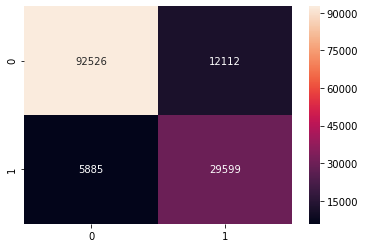

In [39]:
model = LGBMClassifier(objective='binary', boosting_type='gbdt', max_depth=20)
execute_model_stratified_kfold(model)

Score = 0.87124 
Precision = 0.83381 
Recall = 0.70871 


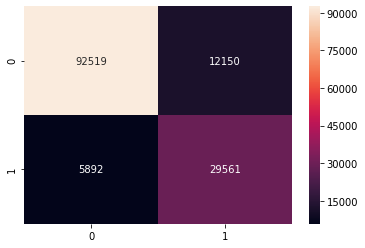

In [46]:
model_2 = LGBMClassifier(objective='binary', boosting_type='gbdt')
execute_model_stratified_kfold(model_2)

In [44]:
len(Y_test), sum(Y_test == 1), sum(Y_test == 0)

(140122, 41711, 98411)

In [45]:
??LGBMClassifier